# Documentation of on-going work

###### Author : Ishaan Bhat


This work seeks to develop a model that can reconstruct the entire data sample when presented with  partial or noisy instance of that sample. Initial work was pivoted towards creating a generative model that would be trained together with a discriminator (classifier), i.e. a [Generative Adversarial Network (GAN) developed by Goodfellow et al](http://arxiv.org/abs/1701.00160).

In the first phase of the work, efforts were directed to develop a classifier for the CIFAR-10 image data set. The motivation behind this was to be famililar with Tensorflow, CNN architectures, generalization and optimization techniques. 

### Convolutional Neural Networks:

Fully connected neural networks do not scale well with the size of the image due to the large number of parameters that would be required for such a model. CNNs seek to solve this problem by using parameter sharing which exploits the inherent structure present in images. This is done by performing convolution of the input image with a set of *kernels* or *filters* to generate of set of *feature maps*. Each feature map is created as a result of the convolution between the image and a single kernel, thus each feature map uses the same set of parameters. The filter co-efficients are trainable variables, the filter size (local receptive field) and the number of filters are hyper-parameters. Each filter has width and height dimensions considerably smaller than the image dimensions. The depth of the filter is equal to the number of image channels. Each convolution creates a 2-D feature map, a set of filters create of 3-D volume with the depth equal to the number of filters chosen. [Width and height can analysed as follows.](http://cs231n.github.io/convolutional-networks/#conv). Intuitively, it can be seen that each feature map shows us whether the feature the corresponding filter is trained to observe is present in a certain location in the image. The convolution operation is translationally invariant i.e. a certain feature if present in the image will be detected irrespective of its location within the image. 
    
The CNN can be decomposed into the following building blocks:

* **Convolution Layer**:

    
By setting the filter width and height dimensions, we define the *receptive field* for each neuron in the feature map. Thus each neuron with a single feature map reacts to a very small part of the image, thus a feature map would encode only very local features of the input it is fed. 
    
* **Pooling and Normalizing Layer**:

A pooling layer is usually inserted between 2 consecutive convolution layers. The pooling operation takes the maximum over a fixed 2-D window given a feature map. It operates independently on each depth slice of the feature volume. By downsampling the feature map, the convolution in the next stage would be trained to detect higher level features since the *effective local receptive feild* of this next convolution w.r.t. the input image has increased in size.

* **Fully Connected Layer**:

After multiple convolution and pooling layers (optionally normalization layers), the output (or readout) layer is usually fully connected to the preceding layer. There can also be multiple fully connected layers. An interesting insight about this layer is that we can imagine the stacked conv layers as reducing the input image to a point in a space of high-level or abstract features. The FC layer(s) learn a non-linear function to perform classification in this space([source](https://stats.stackexchange.com/questions/182102/what-do-the-fully-connected-layers-do-in-cnns)).


### CIFAR-10 Classifier

The model is developed based on [TensorFlow documentation](https://www.tensorflow.org/tutorials/deep_cnn) and the [associated code](https://github.com/tensorflow/models/tree/master/tutorials/image/cifar10). Code developed by the author can be found [here](https://github.com/kilgore92/cifarCNN).


The model has the following architecture:

**INPUT -> [CONV -> RELU -> POOL]x2->[FC]x2->OUTPUT**

The feature maps have a receptive field of 5x5 (and a stride of 1) with 64 maps generated for each convolution layer. The pooling layers use max pooling with a window size of 3x3 (with stride of 2). The output is a vector of size of 10, each element denoting the probability of the class being equal to its index. 

The baseline version of the code uses L2 weight regularization and augments input images by adding various types of noise. For the baseline version, an accuracy of 86.6% was obtained.

**TODO : Add graph**

The model was adapted to use various new architectural changes/optimizations such as Dropout and Batch Normalization. Techniques like adversarial traning were studied but not implemented in the model.


* **Dropout:** 

Dropout was technique proposed by Hinton et al. for the ImageNet 2012 challenge. In this approach, a fixed fraction of (random) activations of the neurons in the FC layers are set to 0 during each training step. Intuitively, it can be seen that this has the effect of approximately combining exponentially many different model configurations. Having fewer weights coming into a particular neuron, complex co-adaptations between neurons are reduced which improves the generalizing behavior of the model. However, for a large enough dataset, dropout isn't very effective because the model no longer has the capacity to *memorize* the samples thereby avoiding overfitting behavior. 

In our model, dropout was applied to the following layers:
* Connecting the output of the 2nd pooling layer to the 1st FC layer
* Connecting the output of the 1st FC layer to the 2nd FC layer

**TODO: Add graph**

* **Batch Normalization:**

Batch Normalization is a technique that is applied to each layer independently in particular before the non-linearity in each layer. This technique operates on the affine term (W\*x + b), wherein this term is normalized to have zero mean and unity variance. In addition to this, it is multiplied by scaling factor and added with a shift factor. Both these factors are trainable and are present to prevent loss of representational power of the model due to the normalization. 

This method seeks to reduce the *internal covariate shift* caused by the change in the distribution of inputs fed to the model (and thus to each layer within the model). The idea that this approach hinges on is that by reducing the covariate shift within the model, learning can be accelerated and the model is less likely to stuck in the saturated regime. Normalization is performed for every mini-batch of data fed to the model. 

This method is regularizing in the sense that normalization of a given training image is dependent on all images present in the mini-batch, so values produced by the model for that trainining example are no longer deterministic. Since batch normalized networks train faster and require fewer steps, it is advised to reduce distortions to input images (data augmentation techniques) to let the model see more *real* examples. 

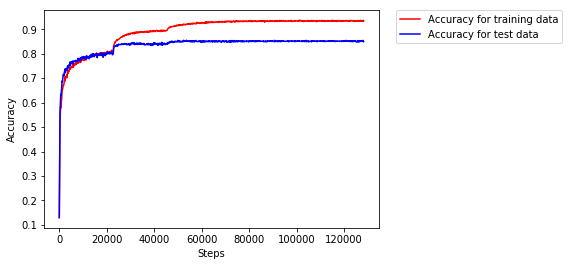

In [1]:
import matplotlib.pyplot as plt
import numpy as np

data_train = np.genfromtxt('train_graph.csv', delimiter = ',',names=['Time','Step','Train_Accuracy'])
data_eval = np.genfromtxt('eval_graph.csv',delimiter = ',',names=['Time','Step','Eval_Accuracy'])


plt.plot(data_train['Step'],data_train['Train_Accuracy'],'r',label="Accuracy for training data")
plt.plot(data_eval['Step'],data_eval['Eval_Accuracy'],'b',label="Accuracy for test data")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.ylabel('Accuracy')
plt.xlabel('Steps')

plt.show()



### Deep Belief Networks

In the second phase of work, after some consideration and analysis about the behavior of GANs, we came to the conclusion that the fundamental architecture of the GAN is not suitable to our work. A GAN estimates the probability distribution of the dataset is it trained to *generate*. This was the insight that led us to focus on it. However, it does not explicitly compute the model distribution, but only provides a way to sample from it. This has led us to review a Markov based approach of Boltzmann machines.

RBMs are building blocks for DBNs . RBMs make inference tractable by prohibiting connections between hidden units of the same layer leading to a factorial distribution, given an image, the state of a hidden unit is independent of other hidden units. An additional restriction is that fowrard and backward connections between layers are symmetric.

In essence, this model allows for an unsupervised method of learning by trying to model the joint probability p(v,h) =>  via the representational power of an RBM (in turn using a composition of RBMs that form a Deep Belief Network). Hinton et al put forward the idea of greedy layer wise learning for DBNs. The DBN can be sampled (using methods like Gibbs sampling) to model the data distribution (thus the DBN is a generative model). This is suitable for tasks such as image reconstruction.

#### Deep dive into RBMs

RBMs belong to a special class of probabilistic graphical models called *Markov Random Fields*. In this model, conditional dependence between random variables is denoted using a graph structure [13]. Each node in the graph can take a value that follows the distribution of the random variable associated with that node. This random variable is conditionally dependent only on nodes in its *neighbourhood*, known as the local Markov property (in space). An MRF can thus be thought to model the joint distribution of the random variables assigned to each node. In RBMs, the neurons are split into visible and hidden layers. Furthermore, connections between neurons belonging to the same layer are disallowed. With this, it can be concluded that given a sample on the visible layer of neurons, the value taken by each hidden neuron is independent of other hidden neurons (and vice vesa).

$$ p(\textbf{h}|\textbf{v}) = \prod_{i} p(h_i | \textbf{v}) $$


$$ p(\textbf{v}|\textbf{h}) = \prod_{j} p(v_j | \textbf{h}) $$

A *Markov Chain* can be constructed by looking at the evolution of the states of the nodes, with values drawn from the distributions followed by the random variables. In such a system, the next state of the system is only dependent on the current state. In an aperiodic and irreducible Markov Chain, after a finite number of transitions, a stationary distribution is reached i.e. the joint probability modelled by the graph converges. This logically leads to the key idea of why RBMs can be used as generative models. **If we want to generate data from some target distribution, it is possible to do so by constructing a Markov chain with a stationary distribution which is equal to the target distribution.**

The stationary joint probability modelled by an MRF has the general form of:

$$ p(\textbf{x})  = 1/Z*exp(-E(\textbf{x}))$$


For an RBM, with split layers, the join probability can be written as,

$$ p(\textbf{v},\textbf{h})  = 1/Z*exp(-E(\textbf{v},\textbf{h}))$$


The stationary distribution for the visible layer is thus given by,

$$ p(\textbf{v})  = 1/Z*\sum_{\textbf{h}}exp(-E(\textbf{v},\textbf{h}))$$

** RBM Properties : **

An RBM wherein both the visible and hidden layer neurons can only take binary values is called a *Binary RBM*. The energy term is parametrized using connection weights between the visible and hidden layers (densely connected feedforward network) and is given in [13]. Using this parametrized energy term, the the conditional probabilities can be written as follows, (proof in [13])

$$ P(H_i = 1 | \textbf{v}) = sgm(\sum_{j=1}^{m} w_{ij}v_j + c_i)$$

$$ P(V_j = 1 | \textbf{h}) = sgm(\sum_{i=1}^{n} w_{ij}h_i + b_j)$$

Using appropriately trained parameters and a technique called *Gibbs sampling*, the RBM is used as a generative model. Gibbs sampling is a technique to produce samples from the stationary distribution of the MRF. Essentially, only a single node (picked randomly) is updated at a time. This technique is guaranteed to converge to the stationary distribution of the MRF (proof in [13]) starting from a random distribution. 

In RBMs, this becomes easier given the fact that nodes belonging to a layer are conditionally independent, thus Gibbs Sampling can be applied to an RBM by updating a layer at a time (instead of a node). Thus, starting from an incomplete sample from the data distribution as the initial distribution applied to the visible layer of the RBM, repeated Gibbs Sampling would eventually lead the MRF to the stationary distribution. By design, this distribution will be the target distribution to be generated. 


** Learning in RBMs: **

To create a generative model using RBMs, the energy term is parametrized and parameter values are adjusted in a way such that the stationary distribution at the visible layer is a good estimate of the distribution that the data to be generated is drawn from. This goal is achevied using *maximum likelihood estimation* which amounts to finding parameters that maximize the probability of the target data distribution being the stationary distribution of the MRF. The likelihood is optimzed in an iterative fashion using gradient descent. 

In a general MRF, the gradient of the likelihood w.r.t to the parameters is given by [14], 

$$E_{model}[\frac{\partial E(\textbf{v},\textbf{h})}{\partial \theta}] - E_{data}[\frac{\partial E(\textbf{v},\textbf{h})}{\partial \theta}]$$

Based on the expression for the energy in [13], it can be shown :

$$ \frac{\partial E(\textbf{v},\textbf{h})}{\partial w_{ij}} = h_iv_j $$

The expectation over the model needs the stationary distribution of the RBM to be known which typically is the learning objective (and thus not known during the course of learning), thus the gradient of the log-likelihood is approximated using a technique called *Constrastive Divergence*. In lieu of the stationary distribution, the expection over the stationary distribution can be approximated by considering finite number of steps of alternating Gibbs sampling i.e. *running* the Markov Chain for a finite number of steps. Thus, the approximation for the gradient becomes :

$$P(h_i = 1 | \textbf{v}^{(0)})v^{(0)}_j - P(h_i = 1 | \textbf{v}^{(k)})v^{(k)}_j$$


Each step of constrastive divergence involves sampling the values of the hidden layer using p(h|v) and using these sampled values generating values at the visible layer by sampling p(v|h). In the initial step of CD, the visible layer is initialized with a training example and this Gibbs chain is continued for k-steps in a k-step CD. The state of the RBM after these k-steps is used as an estimate for the stationary distribution of the model using which the second term of the gradient is approximated. Usually k=1 is sufficient for learning [13].





For generating real values at the visible layer, CD can be used where the generation step i.e. sampling the p(v|h) distribution is modified to sample from a Gaussian distribution with unit variance and mean, [15]

$$ b_j + \sum_{i=1}^{n} w_{ij}h_i$$ 

#### Greedy Layer wise learning in Deep Belief Nets

A Deep Belief Net is essentially a stack of RBMs. Inspired from circuit theory, it is observed that deep architectures are much more efficient to create representations (w.r.t the number of parameters needed) as compared to shallow ones [16]. Hinton et al. have shown that addition of new layers improves the generative ability of the model [11]. The key idea for layer wise learning is to decompose the complex model into a set of simpler ones and learn parameters for each in a sequential manner. 

In this approach, the posterior over the first hidden layer is learnt by  (using CD) presenting the network with the training samples, with all the higher level weights *tied* i.e. not modified. The next hidden layer is then trained by presenting the training samples at the visible layer and using the learnt weights and posterior of the first hidden layer to learn the parameters for the second layer. This continues for all the layers of the DBN. While training a layer *l*, the learnt weights for layers *1* to *l-1* are not changed. Training each layer in this manner is called *unsupervised pre-training* [16]. 

Once each layer has been trained in this greedy fashion, the overall model is further fine-tuned w.r.t a training criterion (eg : MSE, Cross Entropy) using gradient descent to *fit* all the parameters. 

#### Experiments

Certain experiments were performed by building upon a [pre-existing DBN implementation](https://github.com/albertbup/deep-belief-network). Hinton's initial approach to working with continuous valued data samples was used i.e. scaling the data to [0,1] range and using the probability of a binary neuron being 1 (given the sampled state of the hidden layer) as the value "held" by that neuron. A 2-layer DBN was used with a digits dataset part of the scikit-learn python package. The reconstruction error metric was computed as the squared error between the original and reconstructed image. 

Ideally, greedy layer-wise training must be followed by fine-tuning the weights of the entire DBN as whole using some training criterion (**discuss with Mike**). 

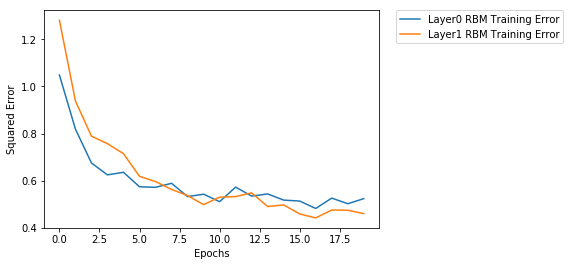

In [6]:
import pickle
import matplotlib.pyplot as plt

with open ('layer_0', 'rb') as fp:
    errorListLayer0 = pickle.load(fp)

with open ('layer_1', 'rb') as fp:
    errorListLayer1 = pickle.load(fp)


plt.plot(errorListLayer0,label='Layer0 RBM Training Error')
plt.ylabel('Squared Error')
plt.xlabel('Epochs')
plt.plot(errorListLayer1,label='Layer1 RBM Training Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

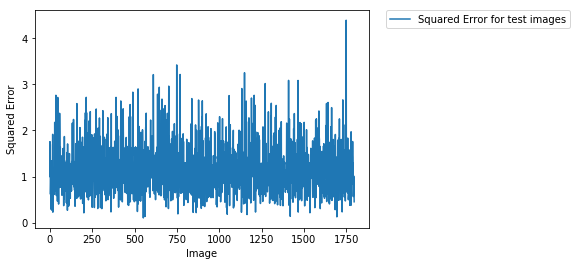

Average reconstruction error over test images : 1.134


In [7]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open ('test_recon', 'rb') as fp:
    testRecon = pickle.load(fp)

plt.plot(testRecon,label='Squared Error for test images')
plt.ylabel('Squared Error')
plt.xlabel('Image')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

print('Average reconstruction error over test images : {0:.3f}'.format(np.mean(testRecon)))


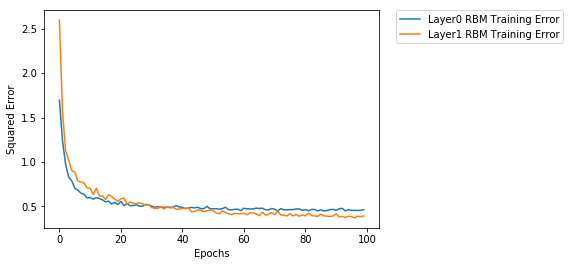

In [5]:
import pickle
import matplotlib.pyplot as plt

with open ('layer_0_100', 'rb') as fp:
    errorListLayer0 = pickle.load(fp)

with open ('layer_1_100', 'rb') as fp:
    errorListLayer1 = pickle.load(fp)


plt.plot(errorListLayer0,label='Layer0 RBM Training Error')
plt.ylabel('Squared Error')
plt.xlabel('Epochs')
plt.plot(errorListLayer1,label='Layer1 RBM Training Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

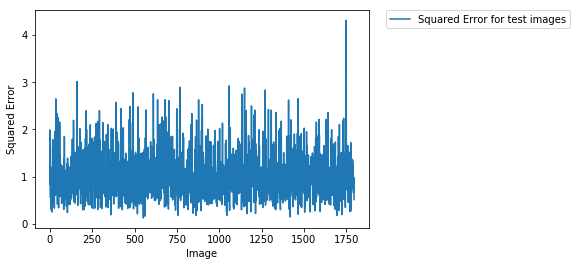

Average reconstruction error over test images : 1.011


In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open ('test_recon_100', 'rb') as fp:
    testRecon = pickle.load(fp)

plt.plot(testRecon,label='Squared Error for test images')
plt.ylabel('Squared Error')
plt.xlabel('Image')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

print('Average reconstruction error over test images : {0:.3f}'.format(np.mean(testRecon)))


The following figures have the DBN with each RBM having 10 CD steps (10 steps of gibbs sampling for every update) with training running for 100 epochs. The idea here is that running more CD steps provides a better approximation of the underlying model distribution and the gradient approximates the true likelihood gradient more closely.

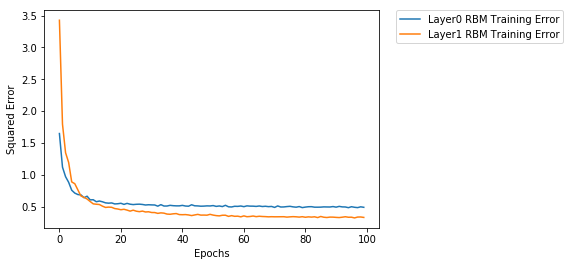

In [7]:
import pickle
import matplotlib.pyplot as plt

with open ('layer_0_cd', 'rb') as fp:
    errorListLayer0 = pickle.load(fp)

with open ('layer_1_cd', 'rb') as fp:
    errorListLayer1 = pickle.load(fp)


plt.plot(errorListLayer0,label='Layer0 RBM Training Error')
plt.ylabel('Squared Error')
plt.xlabel('Epochs')
plt.plot(errorListLayer1,label='Layer1 RBM Training Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

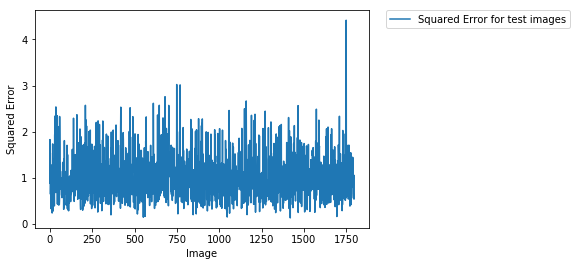

Average reconstruction error over test images : 1.014


In [8]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open ('test_recon_cd', 'rb') as fp:
    testRecon = pickle.load(fp)

plt.plot(testRecon,label='Squared Error for test images')
plt.ylabel('Squared Error')
plt.xlabel('Image')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

print('Average reconstruction error over test images : {0:.3f}'.format(np.mean(testRecon)))


The next set of figures shows training error and average error for test images with number of training epochs increased to 150 and the learning rate reduced to 0.01. The learning rate was bought down to check if the training gets stuck in a local minima.

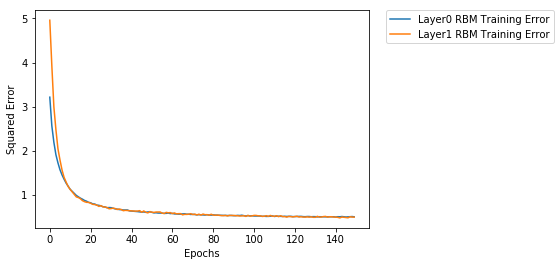

In [9]:
import pickle
import matplotlib.pyplot as plt

with open ('layer_0_lr', 'rb') as fp:
    errorListLayer0 = pickle.load(fp)

with open ('layer_1_lr', 'rb') as fp:
    errorListLayer1 = pickle.load(fp)


plt.plot(errorListLayer0,label='Layer0 RBM Training Error')
plt.ylabel('Squared Error')
plt.xlabel('Epochs')
plt.plot(errorListLayer1,label='Layer1 RBM Training Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

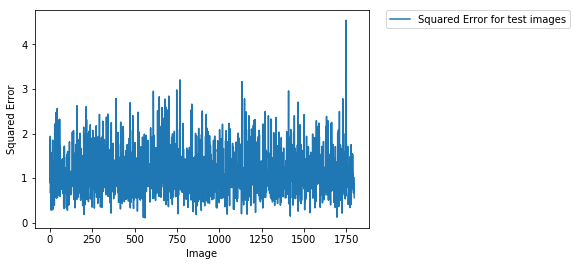

Average reconstruction error over test images : 1.117


In [10]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open ('test_recon_lr', 'rb') as fp:
    testRecon = pickle.load(fp)

plt.plot(testRecon,label='Squared Error for test images')
plt.ylabel('Squared Error')
plt.xlabel('Image')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

print('Average reconstruction error over test images : {0:.3f}'.format(np.mean(testRecon)))


Using the MSE between the original and reconstructed images as the training criterion, SGD over this criterion was performed using back propagation. Tecnhniques like L2 regularization, dropout or alternative optimization schemes like momentum may be used to improve the model performance further. 

The average squared error (over test images) goes down by 50% after fine-tuning i.e. training both layers together. The overall learning performed by the deep belief net is thus a hybrid between unsupervised (greedy layer-wise training) followed by fine-tuning using a (differentiable) training criterion (supervised). Here the distinction between unsupervised and supervised learning is made on the basis of the use of a label based training criterion. While fine-tuning, the original image can be thought of as a label over which the MSE is used as the criterion. 

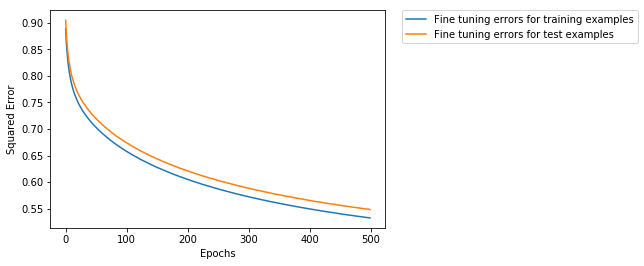

In [4]:
import pickle
import matplotlib.pyplot as plt

with open ('train_finetune', 'rb') as fp:
    training_error = pickle.load(fp)

with open ('test_finetune', 'rb') as fp:
    test_error = pickle.load(fp)


plt.plot(training_error,label='Fine tuning errors for training examples')
plt.ylabel('Squared Error')
plt.xlabel('Epochs')
plt.plot(test_error,label='Fine tuning errors for test examples')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

### Similarity Metric for Images

To gauge the effectiveness of the model reconstructing images, a metric to quantify the similarity between the original and the reconstructed image needs to be defined that in turn also quantifies the efficacy of the model. The RMS (root mean square) metric was considered, which is essentially the euclidean distance in the image space. This was deemed too strict since the model only seeks to estimate the distribution of the dataset. The RMS error would penalize a "good-enough" reconstruction disproportionately.

High-level image features such as SIFT, SURF and ORB were found suitable for the purpose of defining a similarity metric.  The code snippet below uses SIFT features/descriptors to compute the number of *matches* between 2 images. [FLANN based matching](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html#flann-based-matcher) is used to detect similar features in the 2 images. This uses a k-nearest neighbour approach by taking a feature (and it's descriptor) in one image and computing the number of similar features in the image it is being compared with. Good matches are specified by using [Lowe's metric](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) for similarity based on SIFT features.

SIFT and SURF both compute floating point descriptors and key-points. The SURF features extend the the SIFT features by using approximations in certain places to speed up computation. Compared to these, ORB features are binary, a direct consequence of this being, thhe hamming distance between binary features is used to compute matches. [The threshold for the distance is set to be 64.](https://stackoverflow.com/questions/22857398/matching-orb-features-with-a-threshold)

* **Self:**

Matches are computed with itself to as a control measure to estimate the number of *good* matches before calling a reconstruction a faithful one.

* **Slightly Blurred:**

Given the stocahstic nature of the model, the reconstructed image could be noisy. To get an estimate, we compute matches with a gaussian filtered (5x5 kernel) version of the reference image.

* **Very Blurred:**

A larger kernel (50x50) is chosen to get a worst case estimate.

* **Cropped:**

In the extreme case of failure to reconstruct, matches are computed for a (randomly) cropped partial image.

* **Translation:**

The case where the generated version is translated (in x and y direction) w.r.t the original image is considered 

**Correlation between the similarity metric and the process of generating images:** (*Discussion with Mike*)

The process of generating (extended to filling in missing data given partial images) images boils down to training the model with images sampled from a given distribution. Training comprises of adjusting the model parameters in a way such that the (parametrized) model distribution is as close as possible to the true data distribution. This is acheived by finding parameters such that the KL divergence between these distributions is minimum. Minimizing the KL divergence (or maximising the likelihood) is independent of the similarity metrics defined above. But it can be argued that if the model produces a good estimate of the data distribution i.e. it is sucessful in acheiving a low KL divergence at the end of training, the images generated by the model would have similar high-level features compared to the images the model was trained on thereby performing well on the similarity metrics. Thus, the defined metrics while not explicitly being a part of the training will be used to gauge the efficacy of training. 


Original Image 



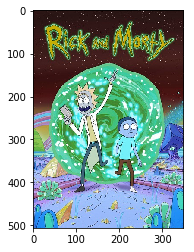

    Transformation    SIFT SURF ORB 
--------------------- ---- ---- ----
  5x5 Gaussian Filter 0.34  0.4 0.32
50x50 Gaussian Filter 0.01 0.03  0.0
          Random Crop 0.04 0.04 0.01
    Image Translation 0.62 0.58 0.63


In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from astropy.table import Table

# Function to compute matches between 2 images
def computeMatchesSIFT(img1,img2):
    # Create the ORB object
    sift = cv2.xfeatures2d.SIFT_create()
    
    sim_metric = 0
    
    # Keypoints and descriptors for the objects
    kp_ref, des_ref = sift.detectAndCompute(img1,None)
    kp_test, des_test = sift.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des_ref,des_test,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
            sim_metric = sim_metric + 1


    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    # Draw first 10 matches.
    img3 = cv2.drawMatchesKnn(img1,kp_ref,img2,kp_test,matches, None, **draw_params)
    
    #plt.imshow(img3),plt.show()
    return sim_metric

def computeMatchesSURF(img1,img2):
    surf = cv2.xfeatures2d.SURF_create(400)
    
    sim_metric = 0
    
    # Keypoints and descriptors for the objects
    kp_ref, des_ref = surf.detectAndCompute(img1,None)
    kp_test, des_test = surf.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des_ref,des_test,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
            sim_metric = sim_metric + 1


    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    # Draw first 10 matches.
    img3 = cv2.drawMatchesKnn(img1,kp_ref,img2,kp_test,matches, None, **draw_params)
    
    #plt.imshow(img3),plt.show()
    
    return sim_metric

def computeMatchesORB(img1,img2):
    orb = cv2.ORB_create()
    sim_metric = 0
    
    # Keypoints and descriptors for the objects
    kp_ref, des_ref = orb.detectAndCompute(img1,None)
    kp_test, des_test = orb.detectAndCompute(img2,None)

    # Use Brute Force matcher + Hamming distance since binary features
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    
    matches = bf.match(des_ref,des_test)

    # Need to draw only good matches, so create a mask
    goodMatches = []
    # ratio test as per Lowe's paper
    for i,m in enumerate(matches):
        # For threshold see: https://stackoverflow.com/questions/22857398/matching-orb-features-with-a-threshold
        if m.distance < 64:
            goodMatches.append(m)
            sim_metric = sim_metric + 1


    # Draw first 10 matches.
    img3 = cv2.drawMatches(img1,kp_ref,img2,kp_test,goodMatches,outImg=None,flags=2)
    
    #plt.imshow(img3),plt.show()
    
    return sim_metric



print('Original Image \n')
refImg = cv2.imread('image.jpg')
height,width = refImg.shape[:2]

plt.imshow(refImg),plt.show()
# Compute self matches
trueMatches = computeMatchesSIFT(refImg,refImg)
trueMatchesSURF = computeMatchesSURF(refImg,refImg)
trueMatchesORB = computeMatchesORB(refImg,refImg)

# Smoothen image
smoothImg = cv2.blur(refImg,(5,5))
smoothMatches = computeMatchesSIFT(refImg,smoothImg)
fracMatchesSmoothSIFT = float(smoothMatches)/float(trueMatches)

smoothMatches = computeMatchesSURF(refImg,smoothImg)
fracMatchesSmoothSURF = float(smoothMatches)/float(trueMatches)

smoothMatches = computeMatchesORB(refImg,smoothImg)
fracMatchesSmoothORB = float(smoothMatches)/float(trueMatches)



# More smoothening
smoothImg = cv2.blur(refImg,(50,50))

# Compute matches with smoothed image
smoothMatches = computeMatchesSIFT(refImg,smoothImg)
fracMatchesSmootherSIFT = float(smoothMatches)/float(trueMatches)

smoothMatches = computeMatchesSURF(refImg,smoothImg)
fracMatchesSmootherSURF = float(smoothMatches)/float(trueMatchesSURF)

smoothImg = cv2.resize(smoothImg,(width,height), interpolation = cv2.INTER_CUBIC)
smoothMatches = computeMatchesORB(smoothImg,refImg)
fracMatchesSmootherORB = float(smoothMatches)/float(trueMatchesORB)


# Cropping
cropImg = refImg[100:200,50:150]
cropMatches = computeMatchesSIFT(refImg,cropImg)
fracMatchesCropSIFT = float(cropMatches)/float(trueMatches)
cropMatches = computeMatchesSURF(refImg,cropImg)
fracMatchesCropSURF = float(cropMatches)/float(trueMatchesSURF)
cropMatches = computeMatchesORB(refImg,cropImg)
fracMatchesCropORB = float(cropMatches)/float(trueMatchesORB)


#Translating the image
xShift = 100
yShift = 100
rows,cols,channels = refImg.shape
shiftMatrix = np.float32([[1,0,xShift],[0,1,yShift]])
shiftImg = cv2.warpAffine(refImg,shiftMatrix,(cols,rows))
shiftMatches = computeMatchesSIFT(refImg,shiftImg)
fracMatchesTransSIFT = float(shiftMatches)/float(trueMatches)
shiftMatches = computeMatchesSURF(refImg,shiftImg)
fracMatchesTransSURF = float(shiftMatches)/float(trueMatchesSURF)
shiftMatches = computeMatchesORB(refImg,shiftImg)
fracMatchesTransORB = float(shiftMatches)/float(trueMatchesORB)


data_matrix = np.array([('5x5 Gaussian Filter',round(fracMatchesSmoothSIFT,2),round(fracMatchesSmoothSURF,2),round(fracMatchesSmoothORB,2)),
                        ('50x50 Gaussian Filter',round(fracMatchesSmootherSIFT,2),round(fracMatchesSmootherSURF,2),round(fracMatchesSmootherORB,2)),
                        ('Random Crop',round(fracMatchesCropSIFT,2),round(fracMatchesCropSURF,2),round(fracMatchesCropORB,2)),
                        ('Image Translation',round(fracMatchesTransSIFT,2),round(fracMatchesTransSURF,2),round(fracMatchesTransORB,2))])

table = Table(data_matrix,names = ('Transformation','SIFT','SURF','ORB'))
print(table)






### Generative Adversarial Networks

In the previous section, the behavior of Deep Belief Nets was examined, which led us to conclude that this technique will not scale to larger datasets effectively. The training algorithm consists of training each RBM in a layer-wise fashion followed by fine-tuning of the (pre-trained) weights w.r.t some training cost/criterion. For data with higher dimensions, it is reasonable to assume that the number of layers needed to create an abstract representation (which can be sampled from) would go up. (*Investigate how/Is there some big-O type relation to this scale? Formal or heuristic?*) which would significantly increase the training time. 

The key idea of using a Markov based approach is to create a Markov Random Field, with a steady state distribution identical to target distribution. Convergence to such a distribution is theoretically guaranteed but is often very slow (*Find a source for this, how slow?*). In addition, even though an explicit expression for the likelihood of an MRF exists, calculating it's gradient is not computationally tractable and thus approximation techniques like *Contrastive Divergence* are used [13]. In [11], it is shown that the gradient computed by the CD method is bounded by the true gradient of the likelihood. However, in [17], it is stated that with such techniques (*variational bounds*) if the approximate posterior (in this case, the k steps in CD-k) or the prior is too weak, the gap between the approximate likelihood and true likelihood becomes too large. In essence, the model ends up learning a distribution that isn't the data distribution. In [17], it is stated that Markov chain based techniques will not scale to a datasets like ImageNet. 

#### Overview of Generative Models 

(*Maybe move this section, by making DBNs and GANs sub-instances of "Generative Models"*)

Essentially, a generative model given a training set (drawn from some p<sub>data</sub>) learns to estimate the distribution (p<sub>model</sub>) and represent it. In [17], generative models have been broadly divided into those which explicitly estimate the density and those that do it in an indirect fashion. Boltzmann machines provide an explicit expression for the modelled joint probablity (via the energy function) and thus falls uder the first category. GANs fall into the latter one since p<sub>model</sub> can only be sampled from, there is no explicit expression for it. Another aspect of GANs that sets it apart from other generative models is that the learning algorithm does not use a maximum likelihood (although an ML based cost function for the generator can be formulated [17]) approach. The expression for the cost function(s) is based on heuristics. 

#### GAN Basics

The model is esentially based on a game between the 2 main components i.e. the *generator* and the *discriminator*. Each of these components is a function (realised by a multi-layer neural network). G(z) is the generator function that samples input noise (given a prior) to generate samples from the data distribution as the output. D(x) is the discriminator function that tries to distinguish between a sample from the true data distribution and a generated sample. The cost function for each component is designed in a way to make the game *adversarial* where then the generator is constantly trying to fool the discriminator, while the discriminator tries its best to detect samples generated by the model and penalize the generator. 

The cost function for the discriminator is defined as: [18]

$$ J^{(D)}(\theta^{(D)},\theta^{(G)}) = (-1/2)E_{x:p_{data}}[log(D(x))] -(1/2)E_{z:p_z}[log(1-D(G(z))]$$

From the expression we see that this resembles the familiar cross entropy cost, only it's calculated on the basis on samples from 2 distinct distributions. Intuitively, this cost seeks to make D = 1 for data samples and 0 for generated samples. The parameters of the discriminator are updated using the gradients on this cost function. 

The cost function for the generator is defined as: [18]

$$ J^{(G)}(\theta^{(D)},\theta^{(G)}) = (-1/2)E_{z:p_z}[log(D(G(z))] $$

It can be seen that minimizing the cost function for the generator increases the change of the discriminator to be fooled i.e. minzing the cost function tries and pushes D(G(z)) to 1. This particular cost function for the generator does not *see* the data directly, instead it sees the performance of the discriminator. Thus the generator is unable to model the data distribution explicitly, but can sample from it. It learns parameters in way that samples from p<sub>z</sub> generate samples from p<sub>data</sub>. 

#### DCGAN Architecture

The generator function G(z) and discriminator function D(x) are realised using convolutional neural networks. The model described in [19] is a result of "extensive model exploration" through which certain key design aspects that work in the context of training GANs work. 

The discriminator and generator functions are realised using an *All convolutional* network where the pooling and FC layers are eliminated. Downsampling in the discriminator is acheived via strided convolutions. This replaces the deterministic pooling by downsampling that is *learned* via model parameters. For the generators, in a similar manner, up-sampling is acheived via fractional convolution or transposed convolution [20].(*Append the CNN section about convolution arithmetic in particular, the transposed convolution and the matrix formulation of the convolution operation*). The fully connected layers present in traditional classification CNNs are eliminated. In the discriminator, the final convolutional layer is flattened and fed to a single sigmoid unit. 

Batch Normalization is found to very effective in the context of DCGANs. It is observed that the use of BN prevents the model from collapsing all (noise) samples to a single data sample (mode collapse) [19]. BN is applied to all layers except the last layer of the generator and the first layer of the discriminator. It has been observed that using the ReLU activation function for units in the generator. The output layer of the generator uses the tanh activation function, which has a bounded activation (*The argument regarding having a bounded activation is not understood clearly at the moment*). In the discriminator, the leaky ReLU has been found to work well.

For training, [18] advocates the use of SGD with momentum. However in [19], Adam optimization is found to perform better. The Adam optimization algorithm is known to work well with sparse gradients [21]. Convolution operations can be visualized as sparse matrix multiplications, thus exploiting this advantage of Adam (*need to verify this. Sparse connectivity matrix ?= Sparse gradients*). Adam is also adaptive i.e. updates are different for different parameters which depend on their first and second order moments. This results in better convergence behavior [21]. 

#### Image In-painting

The technique for *filling in* missing pixels is described in [22] and relies on the use of a trained generative model. In the context of GANs, the high level idea is, given a corrupted image and a binary mask (that corresponds to the blanked out pixles) find a suitable encoding that generates the entire image in a faithful manner i.e. one that looks like it is drawn from p<sub>data</sub>. The key hypothesis here is that the correct encoding that completes the corrupted image is not likely to part of the trained encodings. A loss function is thus designed to find such an encoding (and hence the generated image) in an iterative fashion using backpropagation and gradient descent. 

The loss function is decomposed into 2 seperate expressions, one which deals with local pixel-level properties and the other which deals with higher level image features.

##### Context Loss

This loss seeks to penalize any difference between pixels of the uncorrupted part of the image and the generated image. This is acheived by using the L1 loss between the masked generated image and the corrupted image. However, the mask applied to the generated image is created in a weighted fashion that gives a higher priority to pixels near the missing region and a lesser priority to pixels away from the corruption so as to not penalize slight deviations in the image background. The weighted mask is defined as follows:

For M<sub>i</sub> = 1,
$$ W_i = \Sigma_{j \epsilon N(i)} (1 - M_j)/|N(i)| $$

For M<sub>i</sub> = 0,

$$ W_i = 0 $$

Here, N(i) is defined to be the neighbourhood of a pixel i, w.r.t a window. In [22], the window size was taken to be 7.

The loss is thus defined as,

$$ L_c(z|y,M) = \|W\odot (G(z) - y) \|_{1}$$

This loss penalizes the pixel level differences in the uncorrupted regions corresponding to the input image and the generated image. 

##### Prior Loss

This loss encourages the generated image to be similar to the one draw from p<sub>data</sub>. The original generator loss is thus used. A subtle distinction is even though the expression is exactly the same, during the GAN training gradients of expression are calculated w.r.t the model parameters (kernel co-efficients), however during the recontruction, gradients are calculated w.r.t encoding (z). 

$$ L_p(z) = log(1 - D(G(z)) $$ 


##### Inference

The overall loss function thus becomes,

$$ L(z) = L_c(z|y,M) + \lambda L_p(z) $$ 

Where &lambda; is taken to be 0.003 in [22].

During inference, z is sampled from p<sub>z</sub>, and is updated for multiple iterations using a gradient descent based approach to minizize the loss defined above. [22] uses Adam to perform this update. In [22], for each corrupt image, 1500 backprop iterations were performed to arrive at a "good" encoding i.e. one that generated an image that was reasonably close to p<sub>data</sub>. (*The paper is pretty silent on quantitative measurements and goes so far to showing that an approach based on VAEs that generates blurry images often score better on classical metrics like PSNR/Mean Square Error*).

The final reconstructed image is acheived by using a technique called [Poisson Blending](http://www.ctralie.com/Teaching/PoissonImageEditing/#discreteimplementation) between the generated image and the original corrupted image. Poisson blending makes the boundary between the *filled in* part and the original uncorrupted part of the image seamless. Essentially, it makes the pixels ate the boundary seem continuos while preserving the (pixel-wise) gradients within the part that is filled in.

### Variational Auto-Encoders (VAEs)



### Problem Formulation

In [22], it is stated the GAN architecture used to good at in-paiting relatively "simple" images like faces but does not perform well for real-world images (eg : ImageNet/ CIFAR-10). It also mentions that classical metrics like PSNR/MSE are not good metrics to judge model performance where artifact free and sharp images do worse on these metrics. This leads us to the following vectors to attack the problem:

* Develop meaningful evaluation metrics that measures similarity of the in-painted image w.r.t the ground-truth at a high level instead of pixel level metrics like the PSNR/MSE.

* Understand what part of the underlying generative model does not scale to real-world image. Architecture/ Hyper-parameters/ training algorithm ...

### Quantitative metrics for generative models

A logical pre-cursor to a deep dive to improve generative models, it is necessary to develop a metric that that quantifies the efficacy of said model. The additional constraint for such a metric is that it correlates with how a human perceives the image (visual fidelity) produced by the generative model. Metrics like MSE, PSNR fail to do so [22]. 

Metrics such as average log-likelihood are investigated in [23]. It is concluded that average log-likelihood is not a good metric especially for high dimensioned data, i.e. it is not a suitable metric for generative models dealing with images, no correlation was found between the log-likelihood and the visual fidelity of the generated image. In addition, for a lot of generative models, the calculation of the log-likelihood is often intractable [17,18]. Other metrics like nearest neighbours or euclidean distance (in the data space) have been found to be too volatile [23].

Experiments performed by calculating the SIFT features for an image did not provide conclusive reslts. (* Add a few graphs for illustration*). The motivation behind comparting the SIFT feature vectors between 2 images to gauge similarity, was comparing representations of images in a more abstract sense i.e. comparing the distance between image representations in a higher dimensional space. (*Here higher dimensions is NOT more dimensions, but a more abstract representation of the image*). In the evolution of deep learning methodologies, such *hand engineered* features were left behind to create *learned* feature maps/representations exploiting the spatial structure of the images, used in both unsupervised learning (Auto-encoders) and supervised learning (CNNs). Thus, the guiding principle should be learning representations of images where the euclidean distance (or some distance measure) correlates to the visual fidelity (as perceived by humans).

This idea has been used in [24] in an indirect way by modifying the objective function for a typical VAE. A typical VAE defines its objective function using the popular maximum likelihood approach (which GANs, do not). By modelling the target distribution as a gaussian, the objective function becomes a squared error between the pixels of the training image and the decoded result. It has been established that the mean square error is not a good metric and does not correlate well as to how human's perceive images [23,24]. In [24], the VAE and a GAN have been merged by collapsing the generator from the GAN and the decoder from the VAE into one unit. The pixel mean square error term in the objective function is replaced by the square error term between the values in some feature map (the layer of the feature map is also a hyper-parameter now) for the true image and the generated one. The combined objective function for the entire model thus becomes a sum of the typical GAN objective function and the feature map error term, which in a sense is a *learned* similarity metric. This results in an imporovement in performance over a standard VAE, in terms of the image quality as perceived by humans. Taking this idea, a step further, a discriminator layer from a per-trained GAN can be used to compute this loss term but be interpreted as a similarity metric. 










### References:

1. [Stanford C231 course](http://cs231n.github.io/)
2. [Overview of optimization stategies](http://ruder.io/optimizing-gradient-descent/)
3. [Introduction to Bayesian Statistics](http://www.patricklam.org/uploads/3/8/2/6/3826399/bayesianhour_print.pdf)
4. [Deep dive into backpropagation](http://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/)
5. [Dropout by Srivastava et al.](http://jmlr.org/papers/v15/srivastava14a.html)
6. [Batch Normalization](http://arxiv.org/abs/1502.03167)
7. [Image Net 2012 winning paper](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
8. [Fundamentals of Deep Belief Networks](http://dx.doi.org/10.1162/neco.2008.04-07-510)
9. [OpenCV Feature matching](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html)
10. [SIFT features](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)
11. [Hinton et al. , "A Fast Training Algorithm For Deep Belief Nets"](http://www.mitpressjournals.org/doi/pdf/10.1162/neco.2006.18.7.1527)
12. [Hinton, "Practical Guide to traning Restricted Boltzmann Machines"](http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
13. [Fischer et al., Training Restricted Boltzmann Machines : An Introduction](https://doi.org/10.1016/j.patcog.2013.05.025)
14. [Tang et al., Robust Boltzmann Machines](https://www.cs.cmu.edu/~rsalakhu/papers/robm.pdf)
15. [Hinton et al., Reducing Data Dimensionality Using Neural Networks](http://science.sciencemag.org/content/313/5786/504)
16. [Bengio et al., Greedy Layer-Wise Training of Deep Networks](http://www.iro.umontreal.ca/~lisa/pointeurs/BengioNips2006All.pdf)
17. [Goodfellow I., "NIPS 2016 Tutorial : Generative Adversarial Networks"](http://arxiv.org/abs/1701.00160)
18. [Goodfellow I. et al.,"Generative Adversarial Networks"](http://arxiv.org/abs/1406.2661)
19. [Radford et al.,"Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks"](http://arxiv.org/abs/1511.06434)
20. [Dumolin et al.,"A guide to convolution arithmetic for deep learning"](https://arxiv.org/pdf/1603.07285.pdf)
21. [Kingma et al.,"Adam: a Method for Stochastic Optimization"](https://arxiv.org/abs/1412.6980)
22. [Yeh R., Chen Chen et al., "Semantic Image Inpainting with Perceptual and Contextual Losses"](https://arxiv.org/pdf/1607.07539.pdf)
23. [Theis L., van den Oord A. et al., "A Note on evaluation of Generative Models"](https://arxiv.org/pdf/1511.01844.pdf)
24. [Larsen, Anders Boesen. Lindbo Sønderby, Søren. and Kaae Winther, Ole,"Autoencoding beyond pixels towards a learned similarity metric"](http://arxiv.org/abs/1512.09300)